### Validando a detecção de anomalias para a feature "Número total de valor comprovantes por projeto"

### Features Extracted:

Issue: [#69](https://github.com/lappis-unb/salic-ml/issues/69)
- https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira

#### Recarregar automaticamente os módulos

In [1]:
%load_ext autoreload
%autoreload 2

### Importing data

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv
from salicml.utils.utils import debug

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

#### PLANILHA ORCAMENTARIA

QUERY: /data/scripts/planilha_orcamentaria.sql


In [23]:
dt_orcamentaria_name = 'planilha_orcamentaria.csv'
usecols = ['PRONAC', 'idSegmento', 'VlTotalAprovado']
dt_items = read_csv(dt_orcamentaria_name, usecols=usecols)
display(dt_items.columns)
dt_items.head()

Index(['PRONAC', 'VlTotalAprovado', 'idSegmento'], dtype='object')

,PRONAC,VlTotalAprovado,idSegmento
0,93004,280.0,51
1,103228,9000.0,33
2,103228,4800.0,33
3,1012471,2900.0,71
4,93932,6000.0,71


### FEATURES 
    - Valor total aprovado por projeto

# Dividindo pronacs de treino e pronacs de teste

50/50

In [25]:
from sklearn.model_selection import train_test_split


all_pronacs = dt_items.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=0.5)


dt_train = dt_items[dt_items['PRONAC'].isin(pronacs_train)]
dt_test = dt_items[dt_items['PRONAC'].isin(pronacs_test)]

In [27]:
print('pronacs_train = {}'.format(pronacs_train))
print('pronacs_test = {}'.format(pronacs_test))

assert (dt_train.shape[0] + dt_test.shape[0]) == dt_items.shape[0]

display(dt_train.head())
display(dt_test.head())

pronacs_train = [ 161082 1112812  147032 ...  163836  123352 1410776]
pronacs_test = [ 130699 1011776  115227 ...  140519 1112581  150822]


,PRONAC,VlTotalAprovado,idSegmento
1,103228,9000.0,33
2,103228,4800.0,33
3,1012471,2900.0,71
6,1012800,5000.0,71
14,106667,1500.0,11


,PRONAC,VlTotalAprovado,idSegmento
0,93004,280.0,51
4,93932,6000.0,71
5,93004,124.0,51
7,90105,30000.0,11
8,90105,76800.0,11


In [29]:
segment_projects = dt_train.groupby(['idSegmento', 'PRONAC']).sum()

display(segment_projects.head())

VlTotalAprovado
idSegmento PRONAC                 
11         97310         506905.78
           102857        921745.00
           104202        493162.50
           106667        444310.00
           106687       1844230.00

### Plotando as distribuiçoes dos segmentos mais comuns

In [32]:
common_segements = segment_projects.groupby(['idSegmento']).count()
common_segements.rename(columns={'VlTotalAprovado': 'NumeroProjetos'}, inplace=True)
common_segements.sort_values(by=['NumeroProjetos'], ascending=False, inplace=True)
display(common_segements.head())

,NumeroProjetos
idSegmento,
11,4751
31,2234
33,2168
4B,1333
12,1203


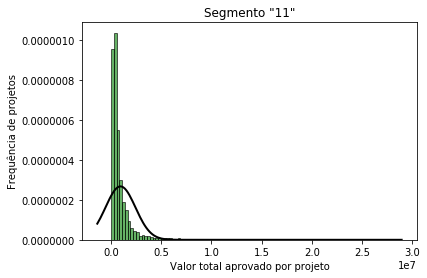

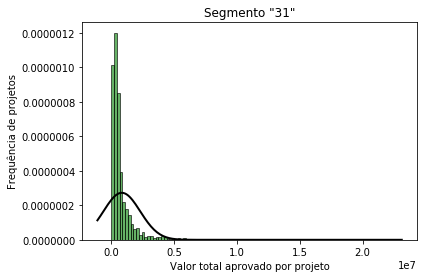

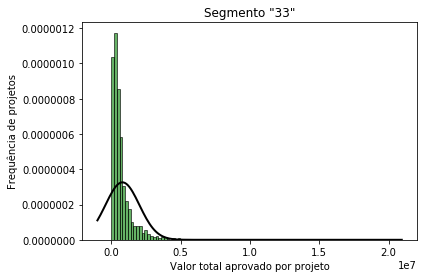

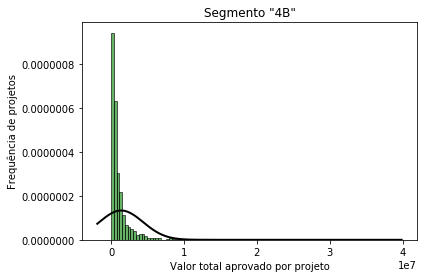

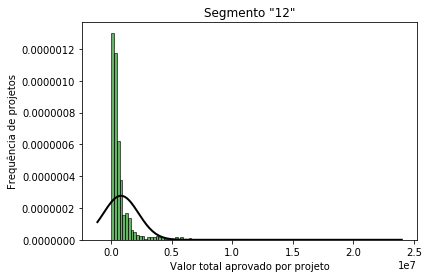

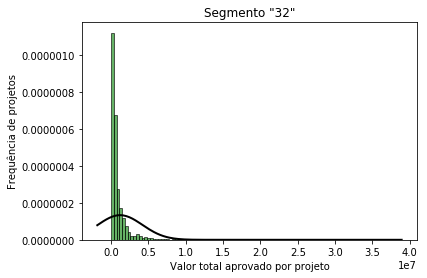

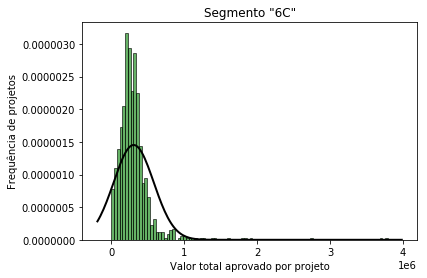

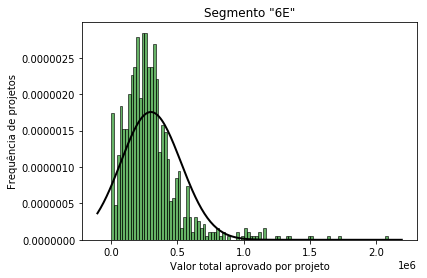

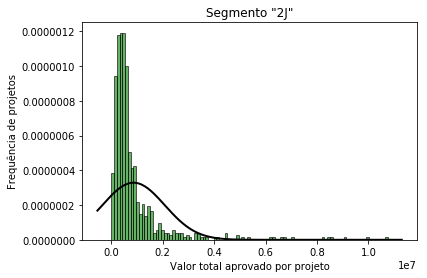

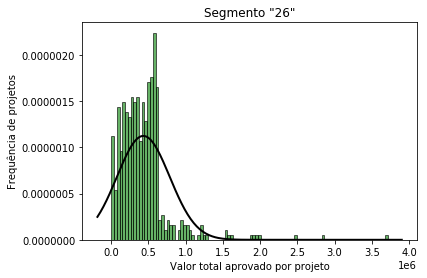

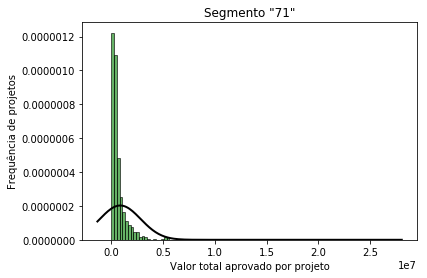

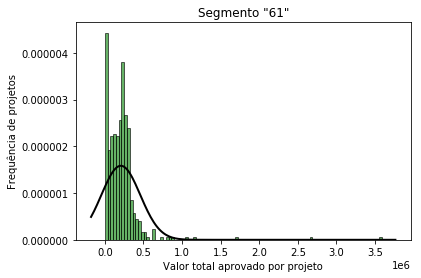

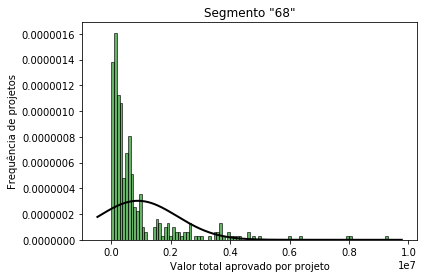

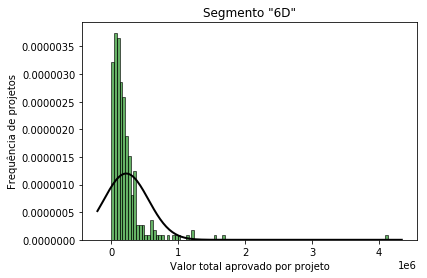

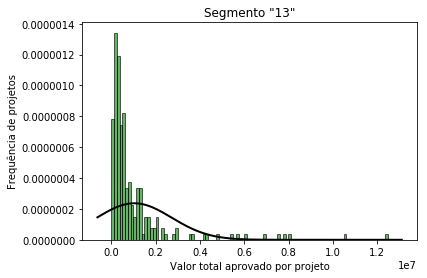

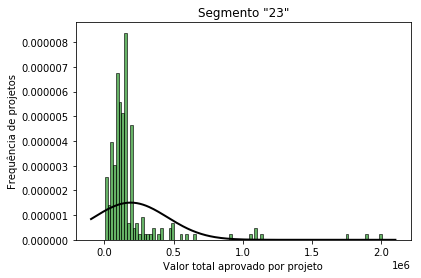

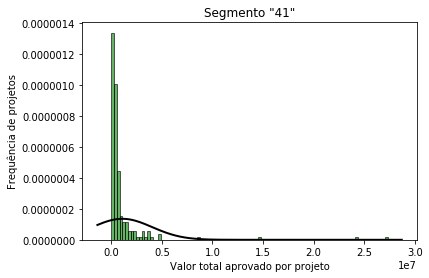

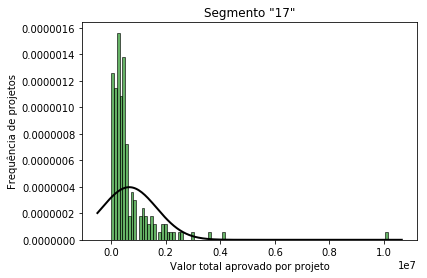

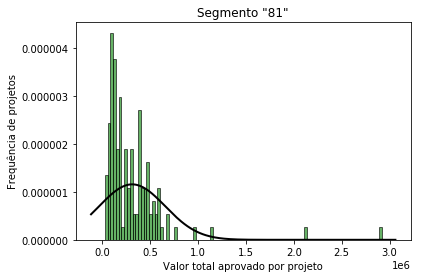

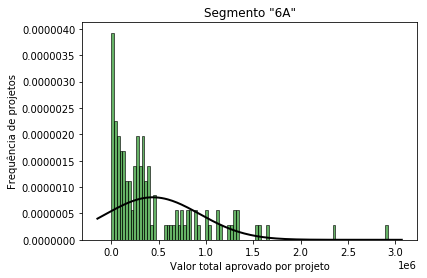

In [33]:
from scipy.stats import norm


def plot_segment(id, approved_values):
    plt.hist(approved_values, bins=100, density=True, stacked=True, alpha=0.6, color='g', edgecolor='black')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.title('Segmento "{}"'.format(id))
    plt.xlabel('Valor total aprovado por projeto')
    plt.ylabel('Frequência de projetos')

    mu, std = np.mean(approved_values), np.std(approved_values)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

for counter, id_segmento in enumerate(common_segements.index.values):    
    projects_total_approved = segment_projects.loc[id_segmento].VlTotalAprovado.values
    plot_segment(id_segmento, projects_total_approved)
    
    counter += 1
    if counter == 20:
        break

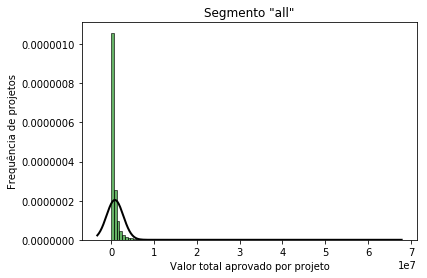

In [35]:
arr = segment_projects['VlTotalAprovado'].values
plot_segment('all', arr)

In [52]:
segment_approved_avg_std = segment_projects.groupby(['idSegmento'])
segment_approved_avg_std = segment_approved_avg_std.agg(['mean', 'std'])

segment_approved_avg_std.columns = segment_approved_avg_std.columns.droplevel(0)

display(segment_approved_avg_std.head())

,mean,std
idSegmento,,
11,9.308901e+05,1.493361e+06
12,8.041455e+05,1.442873e+06
13,1.038135e+06,1.688862e+06
14,2.840818e+06,5.334057e+06
15,2.452326e+05,2.842108e+05


# Calculando a porcentagem de outliers no conjunto de teste

In [51]:
project_approved_grp = dt_items.groupby(['PRONAC'])
project_approved = project_approved_grp.sum()
display(project_approved.head())

,VlTotalAprovado
PRONAC,
90105,5089380.00
90226,233232.00
90335,3422800.39
90413,127357.68
90722,227276.78


In [76]:
from salicml.outliers.gaussian_outlier import is_outlier


def is_total_approved_outlier(pronac):
    assert isinstance(pronac, int)
    
    total_approved = project_approved.loc[pronac]['VlTotalAprovado']
    id_segmento = project_approved_grp.get_group(pronac).iloc[0]['idSegmento']
    
    if not np.isin(id_segmento, segment_approved_avg_std.index):
        raise ValueError('Segment {} was not trained'.format(id_segmento))
    
    mean = segment_approved_avg_std.loc[id_segmento]['mean']
    std = segment_approved_avg_std.loc[id_segmento]['std']
    outlier = is_outlier(total_approved, mean, std)
    return outlier

pronac = int(np.random.choice(dt_test.PRONAC.values))
print('pronac = {}'.format(pronac))
is_total_approved_outlier(pronac)

pronac = 1112575


False

In [78]:
pronacs_test = dt_test.PRONAC.unique()

outlier_arr = []

for i, pronac in enumerate(pronacs_test):
    try:
        outlier = is_total_approved_outlier(int(pronac))
        outlier_arr.append(1.0 if outlier else 0.0)
    except ValueError as err:
        print(err)
    
describe = pd.DataFrame(outlier_arr).describe()
display(describe)

Segment 9O was not trained
Segment 5X was not trained
Segment 4H was not trained
Segment 2S was not trained
Segment 18 was not trained
Segment 18 was not trained
Segment 18 was not trained
Segment 5X was not trained
Segment 6S was not trained
Segment 6S was not trained


,0
count,20568.000000
mean,0.049981
std,0.217910
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Análise dos resultados

Para `c = 1.5`, esperava-se que `6.68%` dos projetos fossem considerados outliers em termos dos números de itens por projeto. Entretanto, para os conjuntos de treino e teste utilizados e `c = 1.5`, `7.57%`dos projetos foram considerados outliers.

# Contribuições futuras

A celula anterior demonstra um problema na divisão dos pronacs nos conjuntos de treino e teste: alguns segmentos, por exemplo o segmento `9I` ficaram fora do conjunto do treino, o que não permite detectar anomalias para este segmento e os demais que não foram incluidos no conjunto de treino. Portanto uma contribução futura desejável é que o conjunto de treino garanta que para segmento, pelo menos 50% do total dos projetos para aquele segmento esteja dentro do conjunto de pronacs de treino.